In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('/Users/sivaprasanth/Documents/DL/Ex9/ml-100k/u.data', sep='\t', names=column_names)

In [3]:
data['rating'] = data['rating'].apply(lambda x: 1 if x >= 3 else 0)  # Convert ratings to binary format

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

In [5]:
train_data = train_data[['user_id', 'item_id', 'rating']].values.astype(np.float32)
test_data = test_data[['user_id', 'item_id', 'rating']].values.astype(np.float32)
errors = []
epochs=10

In [6]:
class RBM(tf.keras.layers.Layer):
    def __init__(self, num_hidden, num_visible, **kwargs):
        super(RBM, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        self.num_visible = num_visible

    def build(self, input_shape):
        self.rbm_weights = self.add_weight(shape=(self.num_visible, self.num_hidden),
                                           initializer='random_normal',
                                           trainable=True)
        self.visible_bias = self.add_weight(shape=(self.num_visible,),
                                            initializer='zeros',
                                            trainable=True)
        self.hidden_bias = self.add_weight(shape=(self.num_hidden,),
                                           initializer='zeros',
                                           trainable=True)

    def sample_hidden(self, visible_samples):
        hidden_activation = tf.nn.sigmoid(tf.matmul(visible_samples, self.rbm_weights) + self.hidden_bias)
        hidden_samples = tf.nn.relu(tf.sign(hidden_activation - tf.random.uniform(tf.shape(hidden_activation))))
        return hidden_samples

    def sample_visible(self, hidden_samples):
        visible_activation = tf.nn.sigmoid(tf.matmul(hidden_samples, tf.transpose(self.rbm_weights)) + self.visible_bias)
        visible_samples = tf.nn.relu(tf.sign(visible_activation - tf.random.uniform(tf.shape(visible_activation))))
        return visible_samples

    def call(self, inputs):
        hidden_samples = self.sample_hidden(inputs)
        reconstructed_samples = self.sample_visible(hidden_samples)
        return reconstructed_samples

In [7]:
class DBN(tf.keras.models.Model):
    def __init__(self, layer_sizes):
        super(DBN, self).__init__()
        self.rbm_layers = [RBM(num_hidden=size, num_visible=layer_sizes[i]) for i, size in enumerate(layer_sizes[1:])]

    def pretrain_rbm(self, rbm, data, epochs=epochs, batch_size=32):
        optimizer = tf.keras.optimizers.legacy.Adam()
        mse_loss = tf.keras.losses.MeanSquaredError()
        
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch in tf.data.Dataset.from_tensor_slices(data).batch(batch_size):
                with tf.GradientTape() as tape:
                    reconstructed_data = rbm(batch)
                    loss = mse_loss(batch, reconstructed_data)
                gradients = tape.gradient(loss, rbm.trainable_variables)
                optimizer.apply_gradients(zip(gradients, rbm.trainable_variables))
                epoch_loss += loss.numpy()
            errors.append(epoch_loss)
            print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

    def call(self, inputs):
        x = inputs
        for rbm in self.rbm_layers:
            x = rbm(x)
        return x

In [8]:
np.random.seed(123)
dbn = DBN(layer_sizes=[train_data.shape[1], 50])
for rbm in dbn.rbm_layers:
    dbn.pretrain_rbm(rbm, train_data)

Epoch 1, Loss: 479493850.9296875
Epoch 2, Loss: 479491787.3046875
Epoch 3, Loss: 479491716.3984375
Epoch 4, Loss: 479494312.6171875
Epoch 5, Loss: 479491973.4375
Epoch 6, Loss: 479490636.7578125
Epoch 7, Loss: 479490762.0625
Epoch 8, Loss: 479495335.59375
Epoch 9, Loss: 479496593.9609375
Epoch 10, Loss: 479491322.3046875


In [9]:
extracted_features = dbn(train_data)
print("Extracted Features:")
print(extracted_features)

Extracted Features:
tf.Tensor(
[[0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 1.]
 [0. 1. 0.]
 [1. 1. 0.]], shape=(80000, 3), dtype=float32)


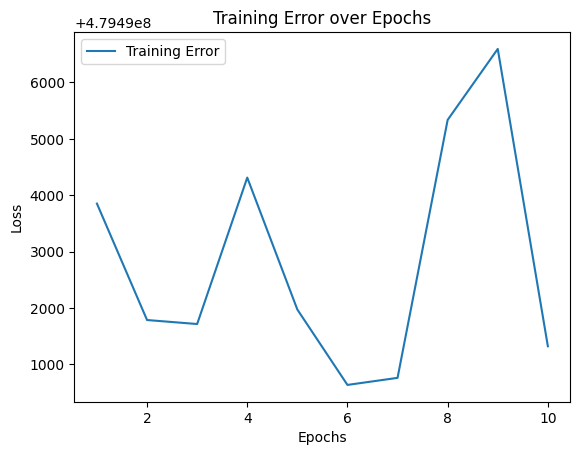

In [10]:
plt.plot(range(1, epochs+1), errors, label='Training Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error over Epochs')
plt.legend()
plt.show()

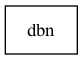

In [11]:
import pydot
tf.keras.utils.plot_model(dbn,to_file='/Users/sivaprasanth/Documents/DL/Ex10/img.png')

In [12]:
dbn.summary()

Model: "dbn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbm (RBM)                   multiple                  203       
                                                                 
Total params: 203 (812.00 Byte)
Trainable params: 203 (812.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
